In [18]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import timeit
import scipy.stats as st
from joblib import Parallel, delayed

## (1) Considering dynamic or % of starting stock

In [1]:
start = timeit.default_timer()


summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785],
    'Annual demand': [28670, 237370, 51831, 13056]
}

class Product:
    def __init__(self, i):
        """
        :type i: int - Product number
        """
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Expected Demand (Lead Time)'][i - 1]

        # Calculate mean and standard deviation of demand using log transformation
        mean_demand = summary['Mean Demand (Lead Time)'][i - 1]
        std_dev_demand = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.mean = np.log(mean_demand) if mean_demand > 0 else 0
        self.sd = np.log(std_dev_demand) if std_dev_demand > 0 else 0


def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            # Placing the order
            q = M - inventory + demand_lead
            order_placed = True
            data['orders'].append(q)
            
            
        if order_placed:
            counter += 1
        
        if counter == lead_time:
            # Restocking day
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data


def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def mc_simulation(product, M, num_simulations=1000):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = MCS(M, product)
        # profit calculation
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        # orders lost calculation
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

def periodic_review(product, low, high, step=50):
    m_range = [i for i in range(low, high, step)]
    review_dict = {}

    for M in m_range:
        p_list, o_list = mc_simulation(product, M)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict


idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']

# percentage factors for low, high, and step
low_percent = 0.8   # 80% of starting stock
high_percent = 1.5  # 150% of starting stock
step_count = 10

# Convert percentages to appropriate integer values
starting_stock_1 = summary['Starting Stock'][0]
starting_stock_2 = summary['Starting Stock'][1]
starting_stock_3 = summary['Starting Stock'][2]
starting_stock_4 = summary['Starting Stock'][3]

low = int(starting_stock_1 * low_percent)
high = int(starting_stock_1 * high_percent)
step = int(step_count)

review = periodic_review(Product(1), low, high, step)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_2 * low_percent)
high = int(starting_stock_2 * high_percent)
step = int(step_count)

review = periodic_review(Product(2), low, high, step)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_3 * low_percent)
high = int(starting_stock_3 * high_percent)
step = int(step_count)

review = periodic_review(Product(3), low, high, step)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_4 * low_percent)
high = int(starting_stock_4 * high_percent)
step = int(step_count)

review = periodic_review(Product(4), low, high, step)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))


df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][3]],
     '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][3]],
     '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][3]],
     '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][3]]},
    index=idx[:-1])  

print(df_product_review)

stop = timeit.default_timer()
print('Time: ', stop - start) 

                                       1              2              3  \
Order-point M                4120.000000   33740.000000    7750.000000   
Expected Profit            189543.976336  577530.973393  422764.878030   
Profit Standard Deviation    4927.642431    5935.752245   22731.949281   

                                       4  
Order-point M                2010.000000  
Expected Profit            514094.892502  
Profit Standard Deviation   72598.228343  
Time:  4527.057910899999


## (2) Conditional sampling (Tracking High-Demand Scenarios)

last_high_demand is initialized with the expected demand.

Each time an order is placed (order_placed is True), last_high_demand is updated to the current day's demand (day_demand).

**Conditional Sampling:**

When order_placed is True, the demand for that day is set to last_high_demand, ensuring that the demand used is influenced by the last high-demand scenario.

Otherwise, daily demand is sampled normally using daily_demand(mean, sd, probability).

This mechanism ensures that when an order is placed, the model focuses on the high-demand scenario encountered previously, which could help better simulate stockout scenarios. However, it's important to note that while this is not traditional importance sampling, it does emphasize critical periods in a way that is similar in spirit to importance sampling by focusing on impactful demand scenarios.

In [2]:
import numpy as np
import pandas as pd
import operator
import timeit

start = timeit.default_timer()

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785],
    'Annual demand': [28670, 237370, 51831, 13056]
}

class Product:
    def __init__(self, i):
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Expected Demand (Lead Time)'][i - 1]

        mean_demand = summary['Mean Demand (Lead Time)'][i - 1]
        std_dev_demand = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.mean = np.log(mean_demand) if mean_demand > 0 else 0
        self.sd = np.log(std_dev_demand) if std_dev_demand > 0 else 0

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    last_high_demand = product.demand_lead  # Initialize with expected demand

    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'weights': []}

    for day in range(1, 365):
        if order_placed:
            day_demand = last_high_demand
        else:
            day_demand = daily_demand(mean, sd, probability)

        data['daily_demand'].append(day_demand)
        data['weights'].append(1)  # Weights are all 1 in this simplified model

        if day % review_period == 0:
            q = M - inventory + demand_lead
            order_placed = True
            data['orders'].append(q)
            last_high_demand = day_demand  # Update the last high-demand scenario
            
        if order_placed:
            counter += 1
        
        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        else:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def mc_simulation(product, M, num_simulations=1000):
    profit_list = []
    for sim in range(num_simulations):
        data = MCS(M, product)
        profit = profit_calculation(data, product)
        profit_list.append(profit)

    return profit_list

def periodic_review(product, low, high, step=50):
    m_range = range(low, high + 1, step)
    review_dict = {}

    for M in m_range:
        p_list = mc_simulation(product, M)
        review_dict[M] = (np.mean(p_list), np.std(p_list))

    return review_dict

low_percent = 0.8
high_percent = 1.5
step_count = 10

starting_stock_1 = summary['Starting Stock'][0]
starting_stock_2 = summary['Starting Stock'][1]
starting_stock_3 = summary['Starting Stock'][2]
starting_stock_4 = summary['Starting Stock'][3]

low = int(starting_stock_1 * low_percent)
high = int(starting_stock_1 * high_percent)
step = int(step_count)

review = periodic_review(Product(1), low, high, step)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_2 * low_percent)
high = int(starting_stock_2 * high_percent)
step = int(step_count)

review = periodic_review(Product(2), low, high, step)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_3 * low_percent)
high = int(starting_stock_3 * high_percent)
step = int(step_count)

review = periodic_review(Product(3), low, high, step)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_4 * low_percent)
high = int(starting_stock_4 * high_percent)
step = int(step_count)

review = periodic_review(Product(4), low, high, step)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][1]],
     '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][1]],
     '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][1]],
     '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][1]]},
    index=['Order-point M', 'Expected Profit', 'Profit Standard Deviation'])

print(df_product_review)

stop = timeit.default_timer()
print('Time: ', stop - start)

                                       1              2              3  \
Order-point M                4120.000000   33750.000000    7800.000000   
Expected Profit            189694.803742  577356.191058  420784.236489   
Profit Standard Deviation    4802.716992    2646.943636   24457.915617   

                                       4  
Order-point M                2080.000000  
Expected Profit            429674.365403  
Profit Standard Deviation   86558.099538  
Time:  3656.689201199999


## (2.1) conditional sampling

I have modified how daily demand is sampled. Instead of sampling completely randomly based on mean and standard deviation, I have introduced a mechanism (if order_placed:) that draws from the last high-demand scenario. This is a form of importance sampling focusing on stockout scenarios.

- Normal Sampling: Before any orders are placed (order_placed is False), demand is sampled normally based on the given mean and standard deviation.
- Historical Context: Once an order is placed (order_placed is True), subsequent demand is drawn from the last high-demand scenario recorded in data['daily_demand'].

Importance sampling seeks to improve estimation accuracy by sampling more frequently from regions where outcomes have greater impact or are rare. In this case:

- Targeting Stockout Scenarios: By drawing demand from the last high-demand scenario (order_placed periods), the simulation emphasizes scenarios where inventory management is crucial—typically when stockouts occur or are imminent.
Enhanced Estimation Accuracy: This approach adjusts the sampling strategy dynamically based on inventory conditions, akin to how importance sampling adapts to target specific outcomes of interest or reduce variance in Monte Carlo estimates.

In [7]:
start = timeit.default_timer()

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785],
    'Annual demand': [28670, 237370, 51831, 13056]
}

idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation']

class Product:
    def __init__(self, i):
        """
        :type i: int - Product number
        """
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Expected Demand (Lead Time)'][i - 1]

        # Calculate mean and standard deviation of demand using log transformation
        mean_demand = summary['Mean Demand (Lead Time)'][i - 1]
        std_dev_demand = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.mean = np.log(mean_demand) if mean_demand > 0 else 0
        self.sd = np.log(std_dev_demand) if std_dev_demand > 0 else 0

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'weights': []}

    for day in range(1, 365):
        if order_placed:
            day_demand = data['daily_demand'][-1]
        else:
            day_demand = daily_demand(mean, sd, probability)

        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            q = M - inventory + demand_lead
            order_placed = True
            data['orders'].append(q)
            data['weights'].append(q / (M + demand_lead))  
            
        if order_placed:
            counter += 1
        
        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def mc_simulation(product, M, num_simulations=1000):
    profit_list = []
    for sim in range(num_simulations):
        data = MCS(M, product)
        profit = profit_calculation(data, product)
        profit_list.append(profit)

    return profit_list

def periodic_review(product, low, high, step=50):
    m_range = range(low, high + 1, step)
    review_dict = {}

    for M in m_range:
        p_list = mc_simulation(product, M)
        review_dict[M] = (np.mean(p_list), np.std(p_list))

    return review_dict

low_percent = 0.8
high_percent = 1.5
step_count = 10

starting_stock_1 = summary['Starting Stock'][0]
starting_stock_2 = summary['Starting Stock'][1]
starting_stock_3 = summary['Starting Stock'][2]
starting_stock_4 = summary['Starting Stock'][3]

low = int(starting_stock_1 * low_percent)
high = int(starting_stock_1 * high_percent)
step = int(step_count)

# periodic review 
review = periodic_review(Product(1), low, high, step)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_2 * low_percent)
high = int(starting_stock_2 * high_percent)
step = int(step_count)

review = periodic_review(Product(2), low, high, step)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_3 * low_percent)
high = int(starting_stock_3 * high_percent)
step = int(step_count)

review = periodic_review(Product(3), low, high, step)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_4 * low_percent)
high = int(starting_stock_4 * high_percent)
step = int(step_count)

review = periodic_review(Product(4), low, high, step)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][1]],
     '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][1]],
     '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][1]],
     '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][1]]},
    index=idx)  

print(df_product_review)

stop = timeit.default_timer()
print('Time: ', stop - start)

                                       1              2              3  \
Order-point M                4120.000000   33750.000000    7780.000000   
Expected Profit            189839.240632  577253.532268  420926.832582   
Profit Standard Deviation    5159.120552    6003.569416   23107.128704   

                                       4  
Order-point M                2040.000000  
Expected Profit            433685.438455  
Profit Standard Deviation   91148.322538  
Time:  3724.5845501999993


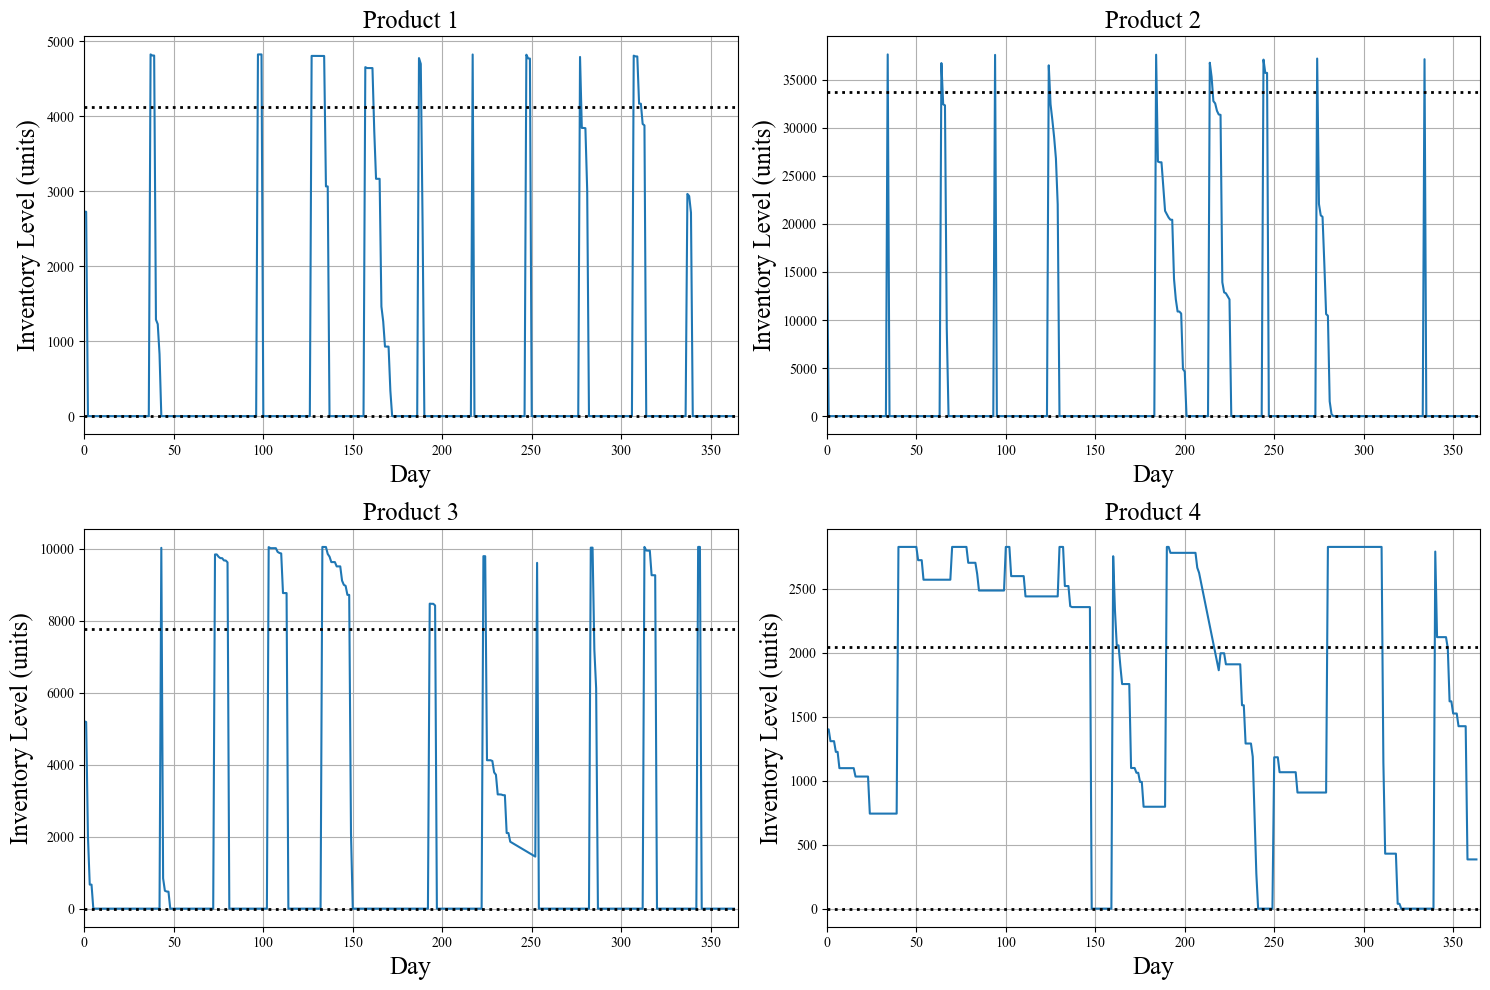

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_inventory(product, M, ax):
    data = MCS(M, product)
    ax.plot(data['inv_level'], linewidth=1.5)
    ax.axhline(M, linewidth=2, color="k", linestyle=":")
    ax.axhline(0, linewidth=2, color="k", linestyle=":")
    ax.set_xlim(0, 365)
    ax.set_ylabel('Inventory Level (units)', fontsize=18)
    ax.set_xlabel('Day', fontsize=18)
    ax.set_title(f"Product {product.i}", fontsize=18)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plot_inventory(Product(1), 4120, axs[0, 0])
plot_inventory(Product(2), 33750, axs[0, 1])
plot_inventory(Product(3), 7780, axs[1, 0])
plot_inventory(Product(4), 2040, axs[1, 1])

plt.tight_layout()
plt.show()


In [ ]:
## C